<a href="https://colab.research.google.com/github/CSSamarasinghe/SE4050_Assignment/blob/IT21388934/cnn_sentimantAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing data**

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-reviews-for-sentianalysis-finegrained-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2078107%2F3499094%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241003%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241003T164549Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D25a30a2ad799910d48f45f67793fb1d09f31560ae3773fa14870108018fa213261ae62aeb020867952a30d8094a21359c2546a6475193ac986bc2645a191d848c7223dbd5c68600aeb8f17d5a979be9750827328816b6743cf0d74ca79e5a28878f8606f4d3cd2176678d18b8a70a20bbf9be8037aa238d4b56bd1a0ba1a8d1fb4003bbd12f51fa6d438aaa8a7e8fa90a9291e62969f7df78c34dc6a71c76fb2f1c11e2964127136ec4d5554e9f1bdd7c530f8ddf987a08dd6cb91a849e4e98a2089149d22cb00ca687688c756071af4270e392fd79699c1f4a35ca16597523ca8bfe37fea11d5911465ea51d6eb17c1e3663da806763c8ef4e96e1f0a9ae9ab'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 654512809 bytes downloaded
Downloaded and uncompressed: amazon-reviews-for-sentianalysis-finegrained-csv
Data source import complete.


**Checking the data set**

In [2]:
import pandas as pd

# Load the dataset
train = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/train.csv')
test = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/test.csv')

# Check the column names
print("Training data set")
print(train.columns)
print(train.shape)

print("Testing data set")
print(test.columns)
print(test.shape)

Training data set
Index(['class_index', 'review_title', 'review_text'], dtype='object')
(3000000, 3)
Testing data set
Index(['class_index', 'review_title', 'review_text'], dtype='object')
(650000, 3)


In [3]:
!pip install tensorflow


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# Reduce the dataset to a manageable size (e.g., 5000 samples)
train_sample = train.sample(n=200000, random_state=42)

test_sample = test.sample(n=60000, random_state=42)

In [6]:
texts = train_sample['review_text'].astype(str).values  # Text reviews
labels = train_sample['class_index'].values  # Sentiment classes (e.g., 0, 1, 2, 3, 4)


In [7]:
# Tokenization and padding

max_length = 200  # Max length for each review
vocab_size = 10000  # Vocabulary size (can tune this)

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')


In [8]:
# Step 5: Preprocess Labels
# Convert sentiment classes to numerical labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
# Convert to categorical (one-hot encoding)
categorical_labels = to_categorical(encoded_labels, num_classes=5)

In [9]:
# Step 5: Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, categorical_labels, test_size=0.2, random_state=42)

In [10]:
# Step 7: Prepare Testing Data
# Preprocess the separate test dataset
test_texts = test_sample['review_text'].astype(str).values  # Text reviews from test set
test_labels = test_sample['class_index'].values  # Sentiment classes from test set

# Tokenize and pad the test texts
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')



In [11]:
# Convert sentiment classes to numerical labels for test data
test_encoded_labels = label_encoder.transform(test_labels)  # Use transform instead of fit_transform
test_categorical_labels = to_categorical(test_encoded_labels, num_classes=5)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

# Step 9: Build the enhanced CNN Model with L1-L2 Regularization
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length))

# First Convolutional Layer with L1-L2 Regularization, Batch Normalization
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Second Convolutional Layer with L1-L2 Regularization, Batch Normalization
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Third Convolutional Layer with L1-L2 Regularization and Batch Normalization
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(BatchNormalization())

# Global Max Pooling Layer instead of Flatten
model.add(GlobalMaxPooling1D())

# Dense Layer with L1-L2 Regularization
model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output Layer with Softmax for multi-class classification (5 classes)
model.add(Dense(5, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)  # Reduce learning rate for more stable updates
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Train the model with the ReduceLROnPlateau callback
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr]  # Include only the ReduceLROnPlateau callback
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.2652 - loss: 51.4928 - val_accuracy: 0.4518 - val_loss: 2.9741 - learning_rate: 1.0000e-04
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4677 - loss: 2.2975 - val_accuracy: 0.4803 - val_loss: 1.4451 - learning_rate: 1.0000e-04
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.5024 - loss: 1.3871 - val_accuracy: 0.4052 - val_loss: 1.5892 - learning_rate: 1.0000e-04
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.5221 - loss: 1.2995 - val_accuracy: 0.5001 - val_loss: 1.3284 - learning_rate: 1.0000e-04
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.5391 - loss: 1.2492 - val_accuracy: 0.4965 - val_loss: 1.3239 - learning_rate: 1.0000e-04
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.5544 - loss: 1.2086 - val_accuracy: 0.5017 - val_loss: 1.3109 - learning_rate: 1.0000e-04
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s

In [13]:
test_loss, test_acc = model.evaluate(test_padded_sequences, test_categorical_labels)
print(f'Test Accuracy: {test_acc}')


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4798 - loss: 1.4165
Test Accuracy: 0.47795000672340393


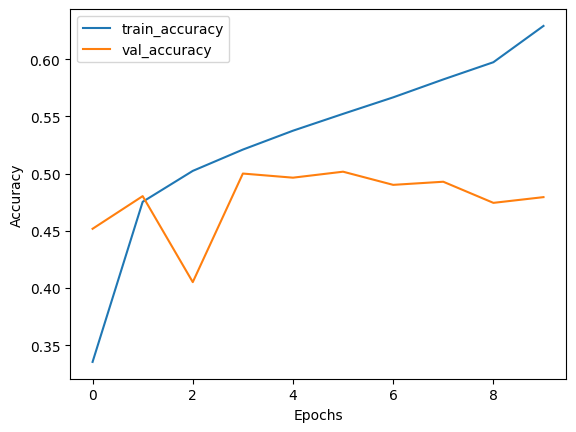

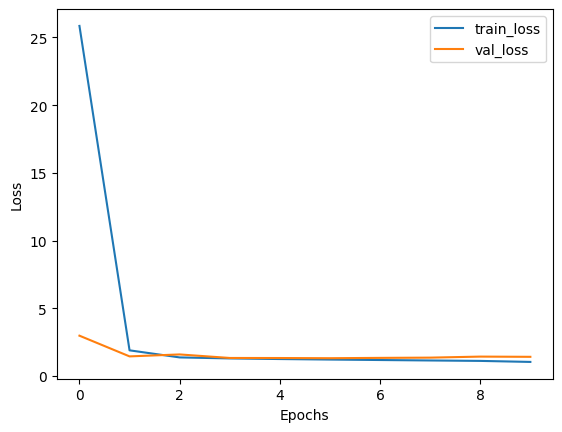

In [14]:
# Step 12: Plot Training and Validation Loss/Accuracy
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Step 12: Model evaluation with metrics (ADDED BELOW)
# Predict on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels
y_val_classes = np.argmax(y_val, axis=1)  # True class labels

# Compute accuracy
accuracy = accuracy_score(y_val_classes, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Compute F1-score, precision, and recall
f1 = f1_score(y_val_classes, y_pred_classes, average='weighted')
precision = precision_score(y_val_classes, y_pred_classes, average='weighted')
recall = recall_score(y_val_classes, y_pred_classes, average='weighted')

print(f'F1-Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Classification report for detailed metrics
print(classification_report(y_val_classes, y_pred_classes))

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy: 0.4794
F1-Score: 0.4839
Precision: 0.4988
Recall: 0.4794
              precision    recall  f1-score   support

           0       0.62      0.56      0.59      8087
           1       0.40      0.53      0.45      7879
           2       0.38      0.42      0.40      7960
           3       0.44      0.40      0.42      8031
           4       0.66      0.49      0.56      8043

    accuracy                           0.48     40000
   macro avg       0.50      0.48      0.48     40000
weighted avg       0.50      0.48      0.48     40000

